In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.MNIST ('.', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.MNIST ('.', train=False, transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [4]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
print(train_dataset.classes)
print(len(train_dataset.classes), " classes")

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
10  classes


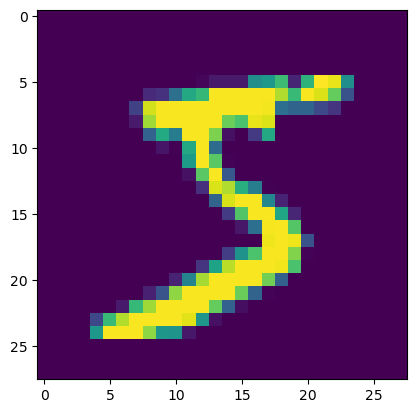

In [6]:
plt.imshow(train_dataset[0][0][0].numpy().reshape(28, 28));

# Create Lenet network

In [7]:
from torch import nn
import torch.nn.functional as F

class LeNetFeatExtractor(nn.Module):
    def __init__(self):
        super(LeNetFeatExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.conv2 = nn.Conv2d(128, 16, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        return x

class LeNetClassifier(nn.Module):
    def __init__(self):
        super(LeNetClassifier, self).__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.feat = LeNetFeatExtractor()
        self.classifer = LeNetClassifier()

    def forward(self, x):
        x = self.feat(x)
        x = self.classifer(x)
        return x

In [8]:
model = LeNet().to(device)

In [9]:

from torchsummary import summary

summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 26, 26]           1,280
            Conv2d-2           [-1, 16, 11, 11]          18,448
LeNetFeatExtractor-3             [-1, 16, 5, 5]               0
            Linear-4                  [-1, 120]          48,120
            Linear-5                   [-1, 84]          10,164
            Linear-6                   [-1, 10]             850
   LeNetClassifier-7                   [-1, 10]               0
Total params: 78,862
Trainable params: 78,862
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.68
Params size (MB): 0.30
Estimated Total Size (MB): 0.98
----------------------------------------------------------------


In [10]:
def evaluate_accuracy(data_iter, net, device):
    net.eval()
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    net.train()
    return acc_sum.item() / n

def train(net, train_iter, test_iter, loss, optimizer, num_epochs, device):

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
    
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
    
        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')


In [11]:
loss = torch.nn.CrossEntropyLoss()
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
train(model, train_iter, test_iter, loss, trainer, num_epochs, device)

epoch 1, loss 0.0016, train acc 0.878, test acc 0.958, time 9.6 sec
epoch 2, loss 0.0004, train acc 0.969, test acc 0.976, time 10.8 sec
epoch 3, loss 0.0003, train acc 0.979, test acc 0.982, time 10.4 sec
epoch 4, loss 0.0002, train acc 0.984, test acc 0.984, time 10.5 sec
epoch 5, loss 0.0002, train acc 0.987, test acc 0.984, time 10.5 sec


In [13]:
model.eval()

LeNet(
  (feat): LeNetFeatExtractor(
    (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1))
  )
  (classifer): LeNetClassifier(
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

Label 5


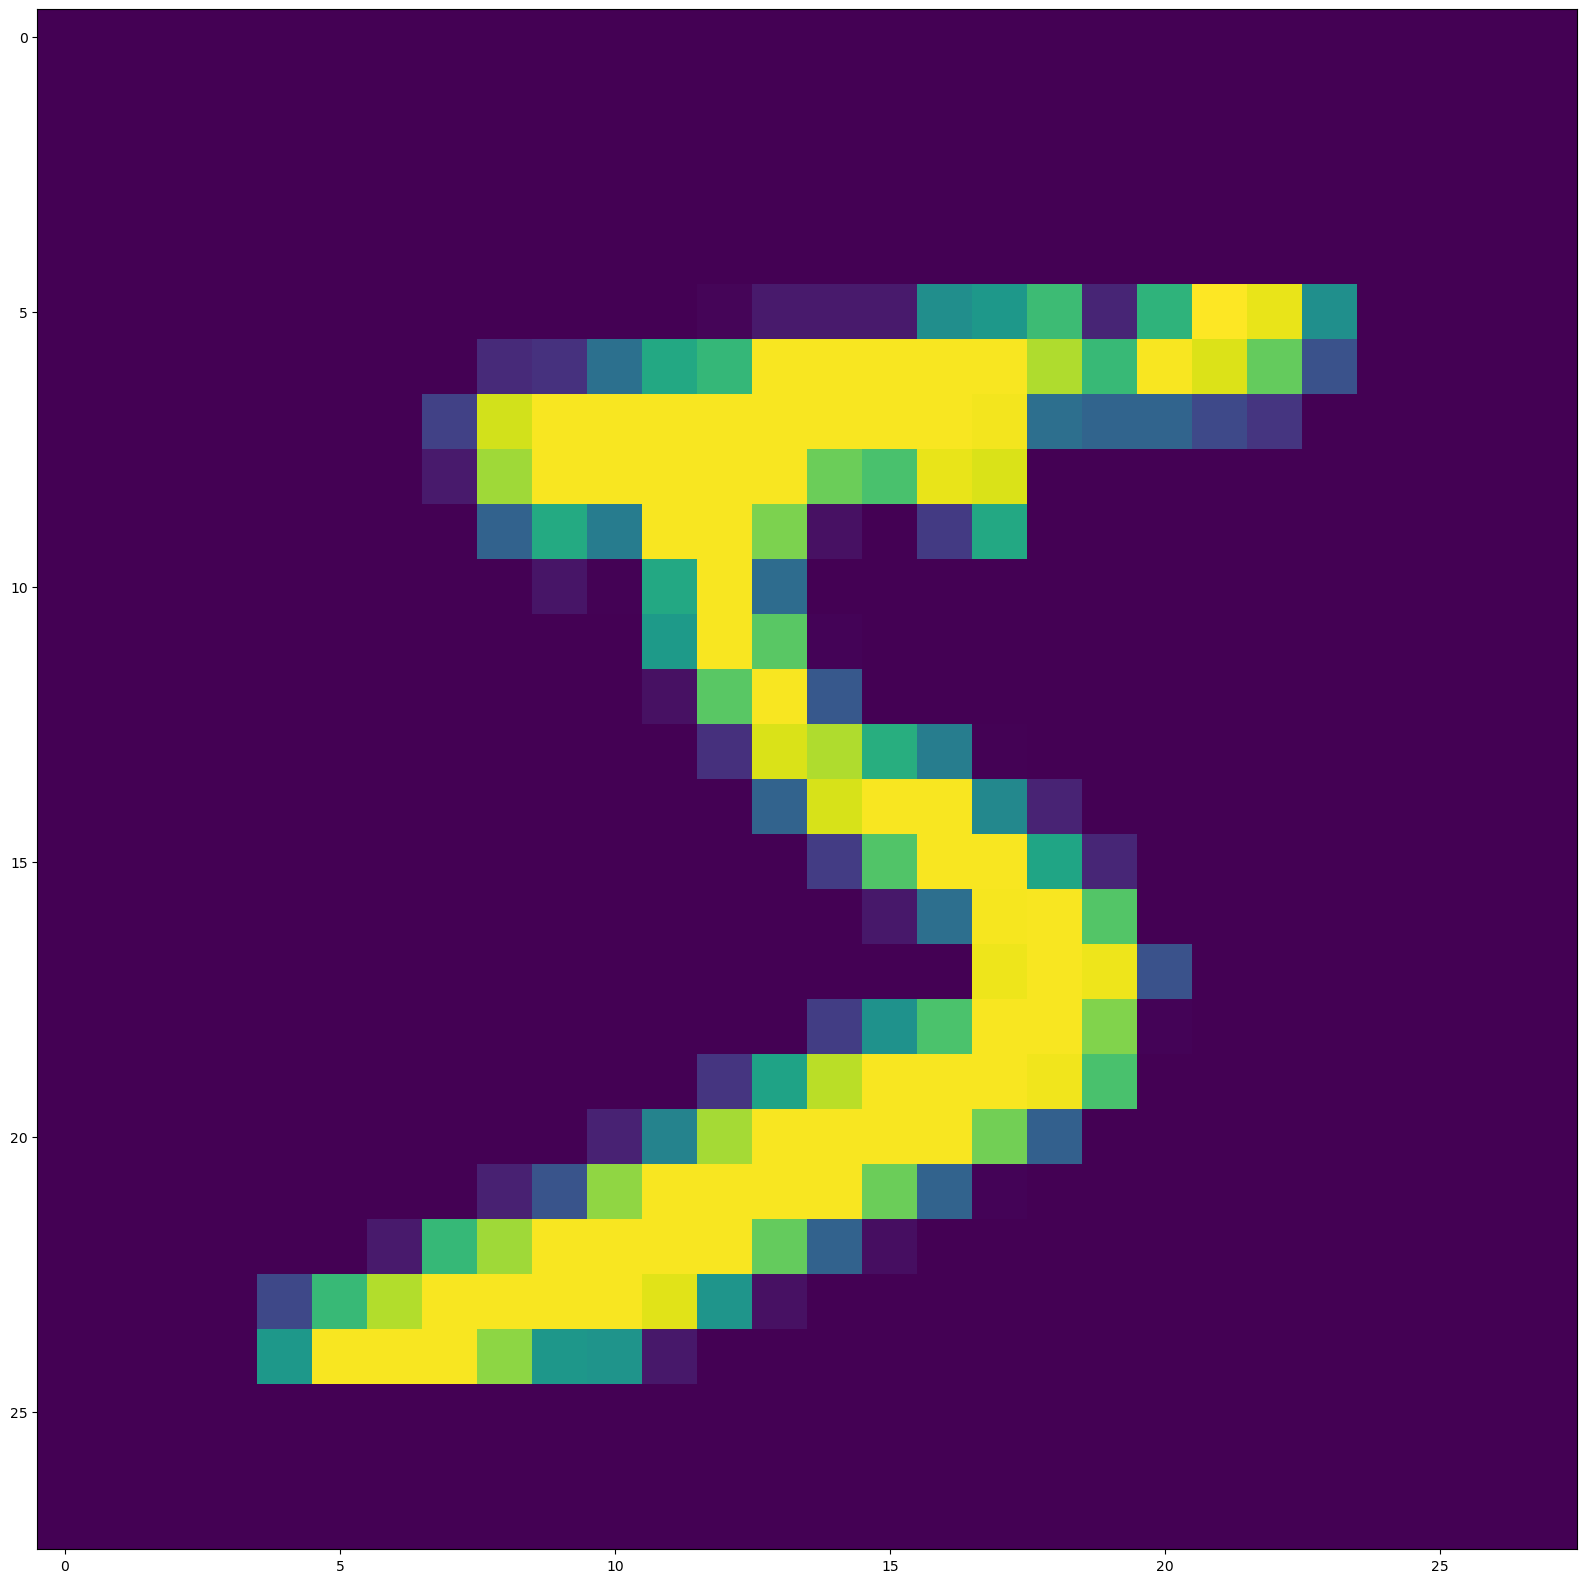

In [92]:
orig_img = train_dataset[0][0]
orig_label = train_dataset[0][1]
plt.imshow(orig_img[0].numpy());
print('Label', orig_label)

In [93]:
orig_img = orig_img.unsqueeze(0)
orig_img.shape

torch.Size([1, 1, 28, 28])

In [94]:
orig_label

5

In [95]:
orig_img = orig_img.to(device)
model(orig_img).argmax()


tensor(5, device='cuda:0')

In [96]:
orig_img = orig_img.squeeze(0)

In [97]:
modulelist = list(model.feat.modules())
modulelist

[LeNetFeatExtractor(
   (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
   (conv2): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1))
 ),
 Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1))]

In [98]:
def to_grayscale(image):
    image = torch.mean(image, dim=0)
    return image
def layer_outputs(image):
    outputs = []
    names = []
    for layer in modulelist[1:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure(figsize=(20,30))


    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i], cmap='gray')
        # plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=30)

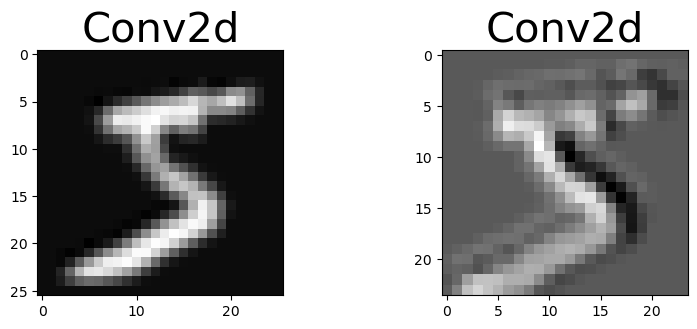

In [99]:
layer_outputs(orig_img)

In [100]:
import numpy as np
def make_saliency_map(img, label):
    image = img.unsqueeze(0).cuda()
    image.requires_grad_()
    output = model.forward(image)
    output[0][label].backward()
    # print(output[0][label])

    grads = image.grad.data.clamp(min=0)
    grads.squeeze_()
    print(grads.shape)
    grads = grads.cpu()
    
    true_image = img.squeeze(0)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu())
    plt.title('Original Image')
    plt.axis('off')

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')

torch.Size([28, 28])


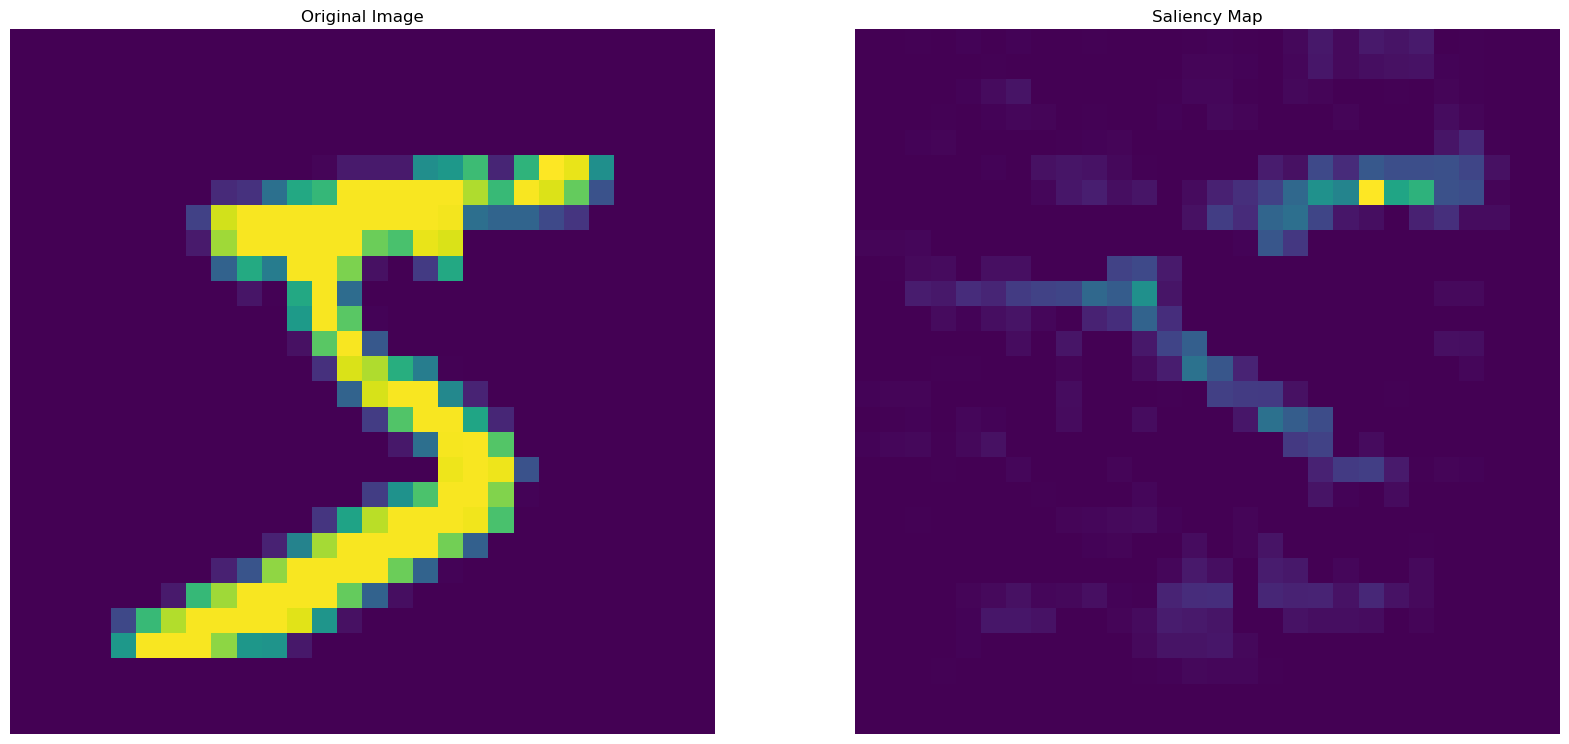

In [101]:
make_saliency_map(orig_img, orig_label)

# Noise which fakes 5 as 3

torch.Size([1, 1, 28, 28])

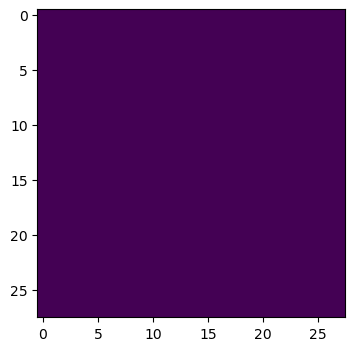

In [102]:
noise = torch.zeros((1, 28, 28))
plt.figure(figsize=(6, 4))
plt.imshow(noise[0].numpy())
noise = noise.unsqueeze(0).to(device)
noise.shape

In [103]:

lr, num_epochs = 0.001, 10
trainer = torch.optim.LBFGS([noise.requires_grad_()])

In [105]:
orig_img = orig_img.unsqueeze(0).to(device)
orig_img.shape

torch.Size([1, 1, 28, 28])

In [106]:
loss = nn.CrossEntropyLoss()

In [107]:
fake_label = torch.zeros((1, 10))
fake_label[0][3] = 1
fake_label

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [108]:
fake_label = fake_label.to(device)

In [109]:
model.eval()
for i in range(num_epochs):
    def closure():
        with torch.no_grad():
            noise.clamp_(0, 1)
        trainer.zero_grad()
        img = orig_img + noise
        label = model(img)
        l = loss(label, fake_label)
        l.backward()
        print(l.item())
        return l
    trainer.step(closure)
    



1.0617313385009766
0.9025490880012512
0.020580321550369263
0.016881927847862244
0.006443202495574951
0.0038733473047614098
0.0015463787131011486
0.0007657456444576383
0.0003494605771265924
0.0001967951684491709
9.154854342341423e-05
5.3881147323409095e-05
2.932505594799295e-05
1.5020257706055418e-05
7.629365427419543e-06
2.7418097943154862e-06
1.6689286894688848e-06
5.960462772236497e-07
3.576278118089249e-07
1.1920928244535389e-07
1.1920928244535389e-07
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


In [110]:
noise = noise.detach().squeeze(0).cpu()

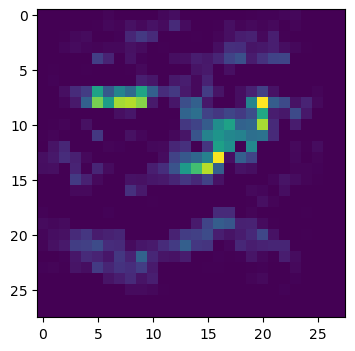

In [111]:
plt.figure(figsize=(6, 4))
plt.imshow(noise[0].numpy())

# test

In [112]:
#orig_img = orig_img.unsqueeze(0)
orig_img.shape

torch.Size([1, 1, 28, 28])

In [113]:
model(orig_img).argmax()

tensor(5, device='cuda:0')

In [114]:
modified_image = orig_img.cpu() + noise.unsqueeze(0)
model(modified_image.cuda()).argmax()

tensor(3, device='cuda:0')

Text(0.5, 1.0, 'Noised image')

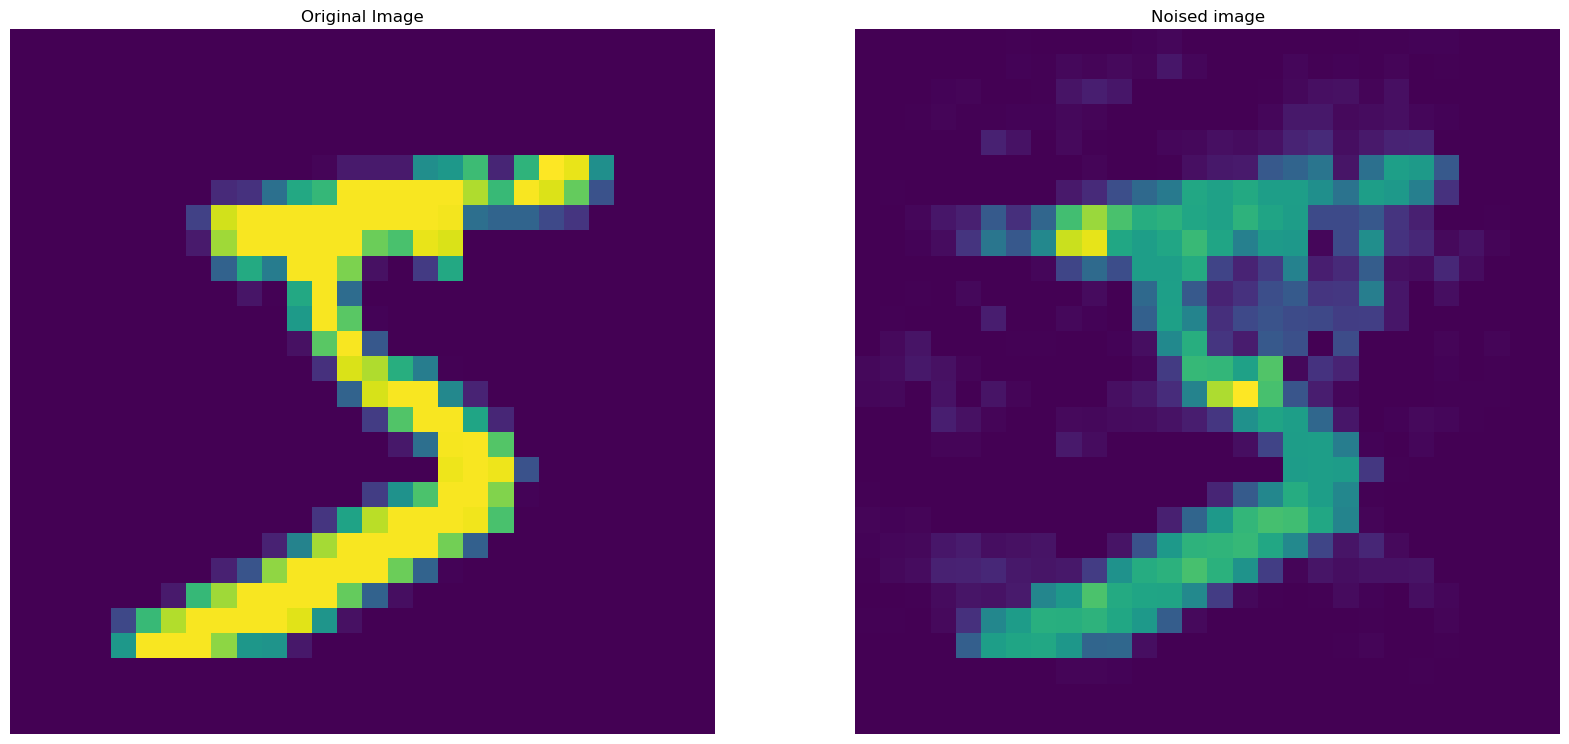

In [115]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 20)

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(orig_img[0][0].cpu().numpy())
plt.title('Original Image')
plt.axis('off')

a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(modified_image[0][0].cpu().numpy())
plt.axis('off') 
plt.title('Noised image')